In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

In [ ]:
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/meeting/final_dataset.csv", na_values=(" ","?","_","-1"), encoding="ISO-8859-1")
df.head()

,CustomerID,InvoiceNo,InvoiceDate,StockCode,Quantity,UnitPrice
0,4728845,57201714,2023-02-02 12:50:00,10707639,6,175.95
1,5740940,56550393,2022-12-26 09:06:00,11094522,3,52.80
2,4540706,57470400,2023-02-15 09:45:00,11286756,72,13.50
3,6468149,54404766,2022-06-22 07:14:00,10561290,3,25.95
4,4861292,56764233,2023-01-11 09:50:00,41106693,12,52.80


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384547 entries, 0 to 384546
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   CustomerID   384547 non-null  int64  
 1   InvoiceNo    384547 non-null  int64  
 2   InvoiceDate  384547 non-null  object 
 3   StockCode    384547 non-null  int64  
 4   Quantity     384547 non-null  int64  
 5   UnitPrice    384547 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 17.6+ MB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,384547.0,5.460060e+06,6.105211e+05,4407545.0,4986956.00,5411072.0,5995124.0,6528482.0
InvoiceNo,384547.0,5.550905e+07,1.291840e+06,53100144.0,54380907.00,55629792.0,56637414.0,57577122.0
StockCode,384547.0,1.455507e+07,9.613060e+06,4830978.0,10622631.00,10944309.0,11227347.0,43573374.0
Quantity,384547.0,3.952200e+01,5.468851e+02,3.0,6.00,18.0,36.0,242985.0
UnitPrice,384547.0,1.258017e+02,4.103132e+04,0.9,25.95,40.5,77.7,25444281.6


In [ ]:
df.drop_duplicates(inplace=True)
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

The dataset contains 0 duplicate rows that need to be removed.


In [ ]:
df.shape[0]

384547

In [ ]:
# Finding the number of unique stock codes
unique_stock_codes = df['StockCode'].nunique()

# Printing the number of unique stock codes
print(f"The number of unique stock codes in the dataset is: {unique_stock_codes}")

The number of unique stock codes in the dataset is: 3193


In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [ ]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,4407545,325
1,4407902,2
2,4408259,75
3,4408616,18
4,4408973,310


In [ ]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,4407545,325,1,222645
1,4407902,2,6,6309
2,4408259,75,4,6996
3,4408616,18,1,1881
4,4408973,310,1,588


In [ ]:
# Calculate the total spend by each customer
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,4407545,325,1,222645,4809132.0,4809132.00
1,4407902,2,6,6309,222011.1,37001.85
2,4408259,75,4,6996,89866.8,22466.70
3,4408616,18,1,1881,89549.1,89549.10
4,4408973,310,1,588,18324.0,18324.00


In [ ]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,4407545,325,1,222645,4809132.0,4809132.00,1
1,4407902,2,6,6309,222011.1,37001.85,85
2,4408259,75,4,6996,89866.8,22466.70,21
3,4408616,18,1,1881,89549.1,89549.10,71
4,4408973,310,1,588,18324.0,18324.00,16


In [ ]:
# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.sort_values().diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,4407902,2,6,6309,222011.1,37001.85,85,2.128378,3,8
1,4408259,75,4,6996,89866.8,22466.70,21,10.884615,6,15
2,4408616,18,1,1881,89549.1,89549.10,71,0.000000,3,5
3,4408973,310,1,588,18324.0,18324.00,16,0.000000,5,12
4,4409687,36,7,1578,86196.6,12313.80,57,3.421053,4,10


In [ ]:
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calculate Trends in Spending
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,4407902,2,6,6309,222011.1,37001.85,85,2.128378,3,8,37001.85,23143.193490,1878.917143
1,4408259,75,4,6996,89866.8,22466.70,21,10.884615,6,15,22466.70,12693.354067,-6342.840000
2,4408616,18,1,1881,89549.1,89549.10,71,0.000000,3,5,89549.10,0.000000,0.000000
3,4408973,310,1,588,18324.0,18324.00,16,0.000000,5,12,18324.00,0.000000,0.000000
4,4409687,36,7,1578,86196.6,12313.80,57,3.421053,4,10,17239.32,9070.148883,984.960000


In [ ]:
customer_data.head(10)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,4407902,2,6,6309,222011.10,37001.85,85,2.128378,3,8,37001.85,23143.193490,1878.917143
1,4408259,75,4,6996,89866.80,22466.70,21,10.884615,6,15,22466.70,12693.354067,-6342.840000
2,4408616,18,1,1881,89549.10,89549.10,71,0.000000,3,5,89549.10,0.000000,0.000000
3,4408973,310,1,588,18324.00,18324.00,16,0.000000,5,12,18324.00,0.000000,0.000000
4,4409687,36,7,1578,86196.60,12313.80,57,3.421053,4,10,17239.32,9070.148883,984.960000
5,4410044,204,1,60,5535.00,5535.00,4,0.000000,6,13,5535.00,0.000000,0.000000
6,4410401,232,1,1590,67193.10,67193.10,58,0.000000,6,9,67193.10,0.000000,0.000000
7,4410758,214,1,684,25416.90,25416.90,11,0.000000,3,9,25416.90,0.000000,0.000000
8,4411115,22,3,4719,154771.65,51590.55,52,5.315789,4,5,51590.55,61676.333849,-58769.100000
9,4411472,33,1,7944,378045.00,378045.00,125,0.000000,2,12,378045.00,0.000000,0.000000


In [ ]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4251 entries, 0 to 4250
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4251 non-null   int64  
 1   Days_Since_Last_Purchase        4251 non-null   int64  
 2   Total_Transactions              4251 non-null   int64  
 3   Total_Products_Purchased        4251 non-null   int64  
 4   Total_Spend                     4251 non-null   float64
 5   Average_Transaction_Value       4251 non-null   float64
 6   Unique_Products_Purchased       4251 non-null   int64  
 7   Average_Days_Between_Purchases  4251 non-null   float64
 8   Day_Of_Week                     4251 non-null   int32  
 9   Hour                            4251 non-null   int32  
 10  Monthly_Spending_Mean           4251 non-null   float64
 11  Monthly_Spending_Std            4251 non-null   float64
 12  Spending_Trend                  42

In [ ]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,4407902,2,6,6309,222011.1,37001.85,85,2.128378,3,8,37001.85,23143.193490,1878.917143,1,0
1,4408259,75,4,6996,89866.8,22466.70,21,10.884615,6,15,22466.70,12693.354067,-6342.840000,1,0
2,4408616,18,1,1881,89549.1,89549.10,71,0.000000,3,5,89549.10,0.000000,0.000000,1,0
3,4408973,310,1,588,18324.0,18324.00,16,0.000000,5,12,18324.00,0.000000,0.000000,1,0
4,4409687,36,7,1578,86196.6,12313.80,57,3.421053,4,10,17239.32,9070.148883,984.960000,1,0


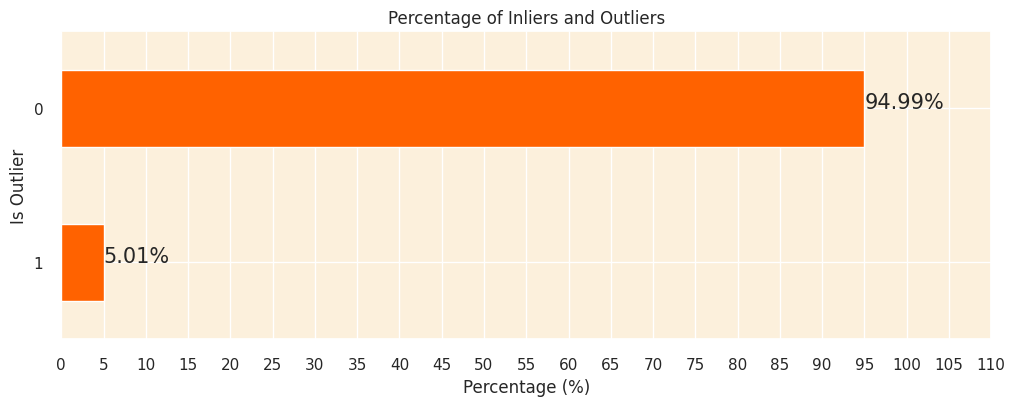

In [ ]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

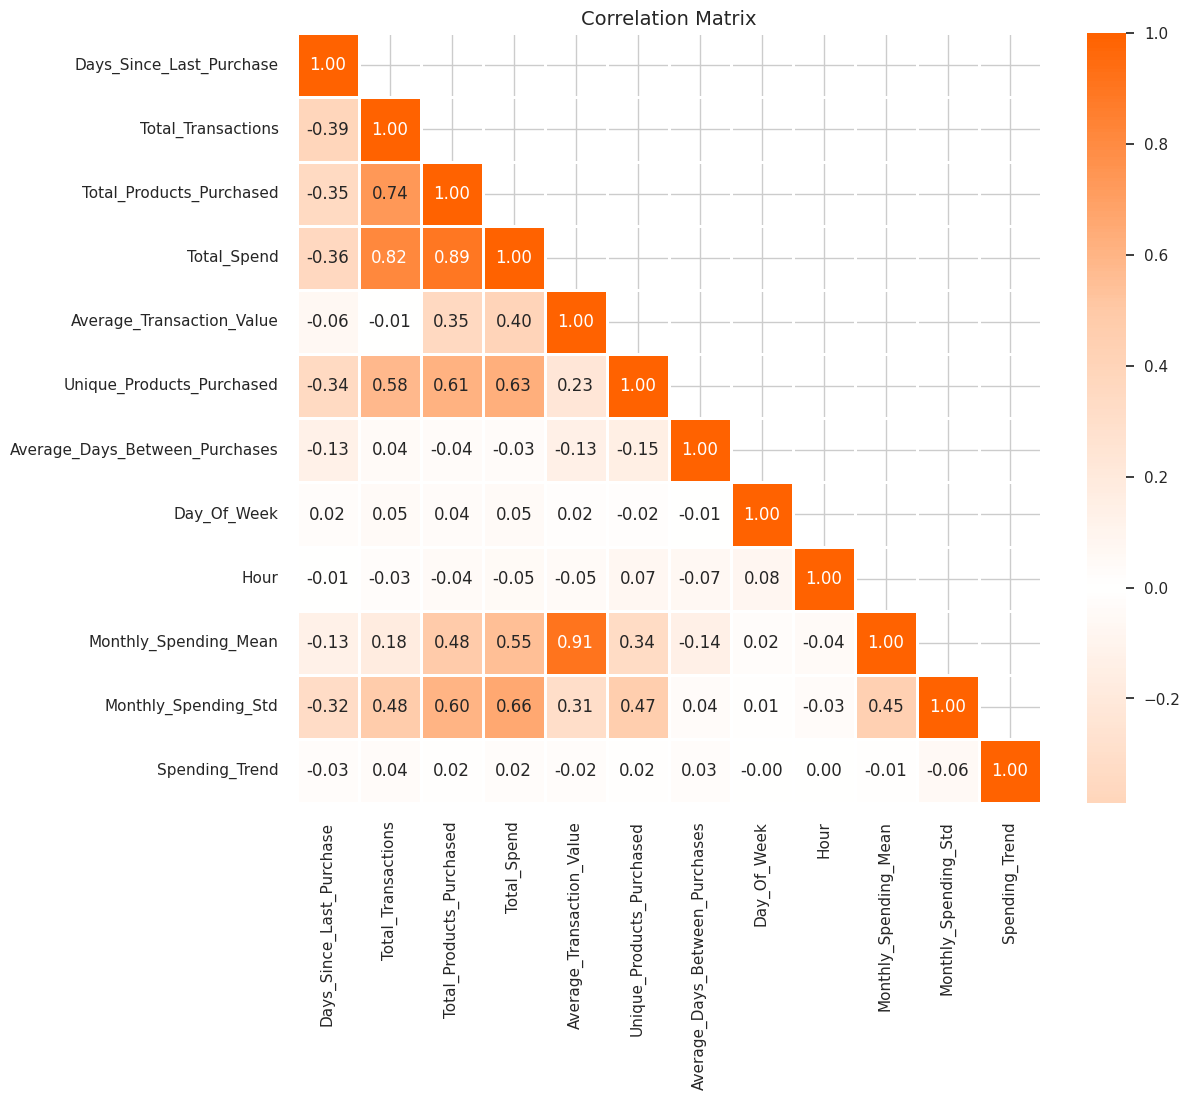

In [ ]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,4407902,-0.912749,0.714100,1.715790,1.861212,1.188443,0.515201,-0.112406,3,-0.228146,0.843988,1.805069,0.228742
1,4408259,-0.173183,0.146587,1.990576,0.246015,0.163974,-0.573291,1.141536,6,2.805150,-0.037488,0.671008,-0.666953
2,4408616,-0.750652,-0.704683,-0.055316,0.242132,4.892090,0.277093,-0.417202,3,-1.528131,4.030686,-0.706529,0.024049
3,4408973,2.207609,-0.704683,-0.572488,-0.628450,-0.128013,-0.658330,-0.417202,5,1.505166,-0.288719,-0.706529,0.024049
4,4409687,-0.568294,0.997856,-0.176509,0.201155,-0.551625,0.038985,0.072712,4,0.638510,-0.354499,0.277802,0.131353


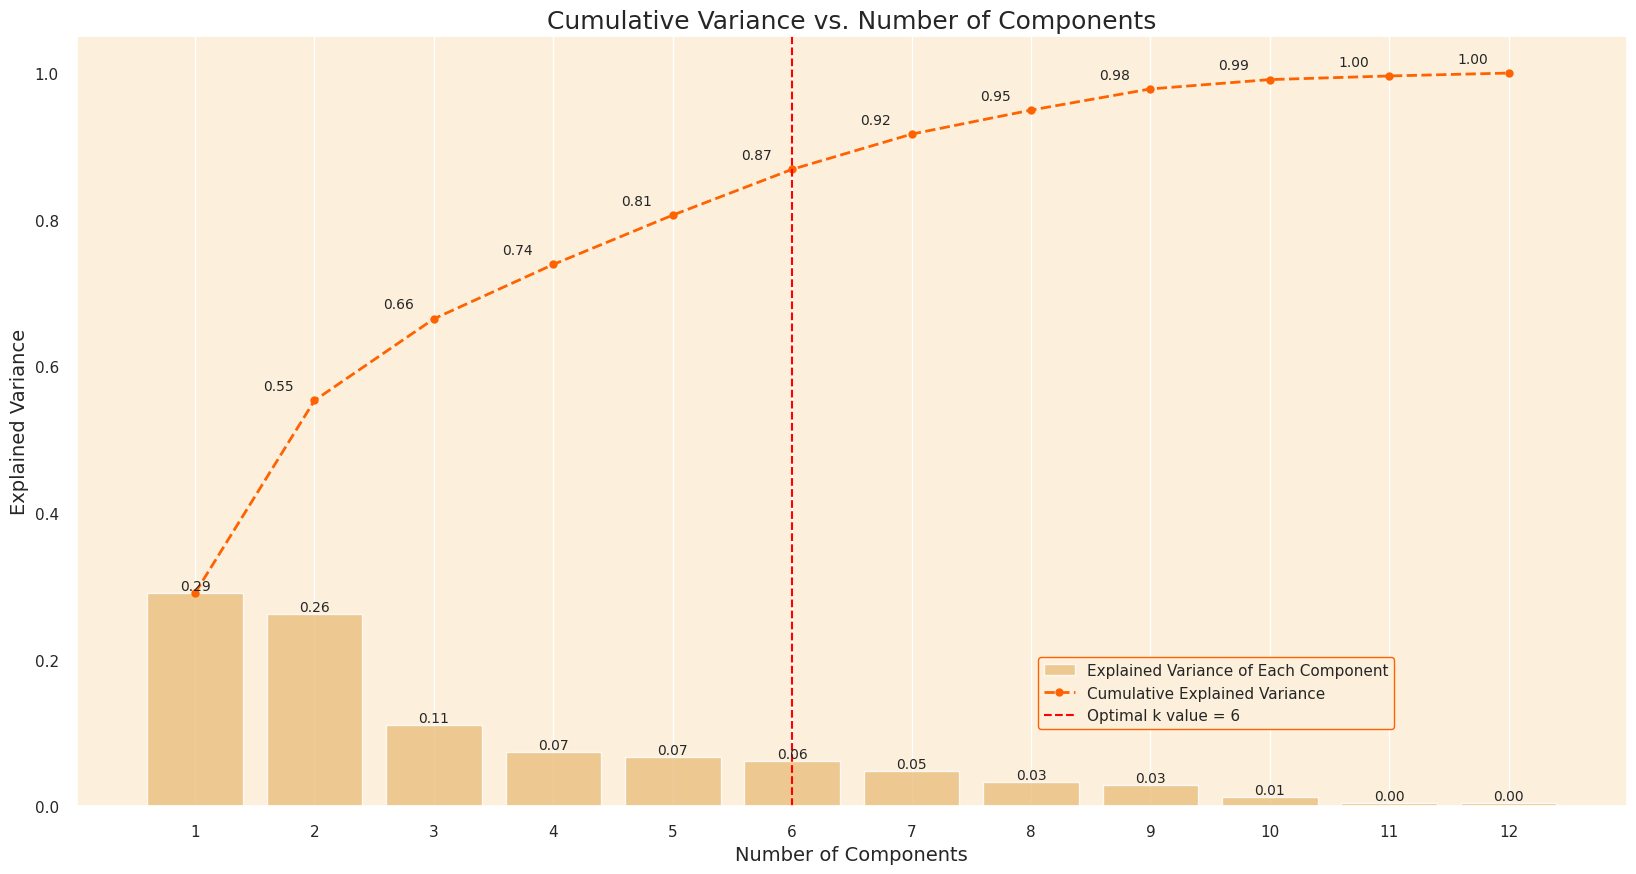

In [ ]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('CustomerID', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}')

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,
           edgecolor='#ff6200')

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

In [ ]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [ ]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
4407902,3.141814,1.574626,0.241083,0.402559,-0.137326,0.087345
4408259,1.742512,-2.159946,-0.548844,-0.811462,0.566714,2.491189
4408616,2.120241,1.335216,5.328417,1.791404,-0.656489,0.392036
4408973,-1.388007,-2.027793,0.930328,-1.345671,-0.165040,0.197086
4409687,0.465541,-0.317814,-1.138726,-0.439094,-0.059440,0.372337


In [ ]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.209087,-0.088251,0.287593,-0.109643,0.004488,-0.335253
Total_Transactions,0.352918,0.091908,-0.383254,-0.055265,0.013801,-0.163960
Total_Products_Purchased,0.415352,0.118613,-0.093200,-0.013007,-0.003473,-0.097764
Total_Spend,0.436557,0.121551,-0.077234,0.008022,-0.008222,-0.090637
Average_Transaction_Value,0.242771,0.070279,0.611727,0.136679,-0.072148,0.173286
Unique_Products_Purchased,0.334543,0.121584,-0.121387,-0.281795,-0.014754,-0.066164
Average_Days_Between_Purchases,-0.030309,-0.003823,-0.275652,0.653829,0.002219,0.537904
Day_Of_Week,0.290031,-0.954797,-0.006285,0.036471,0.001354,-0.024446
Hour,-0.003267,-0.056642,-0.033501,-0.659511,-0.062545,0.698795
Monthly_Spending_Mean,0.308683,0.089556,0.530798,0.107045,-0.064878,0.137841


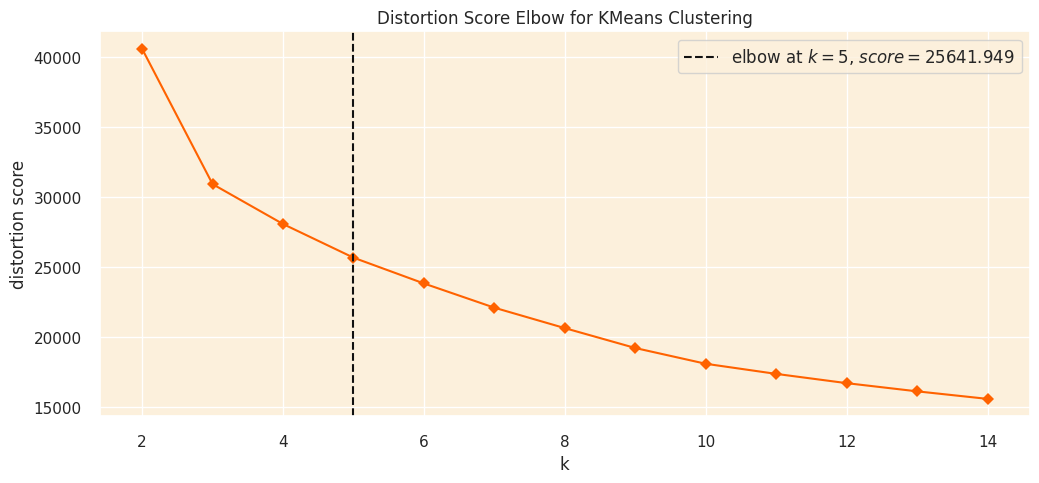

In [ ]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();

In [ ]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom',
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))


    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

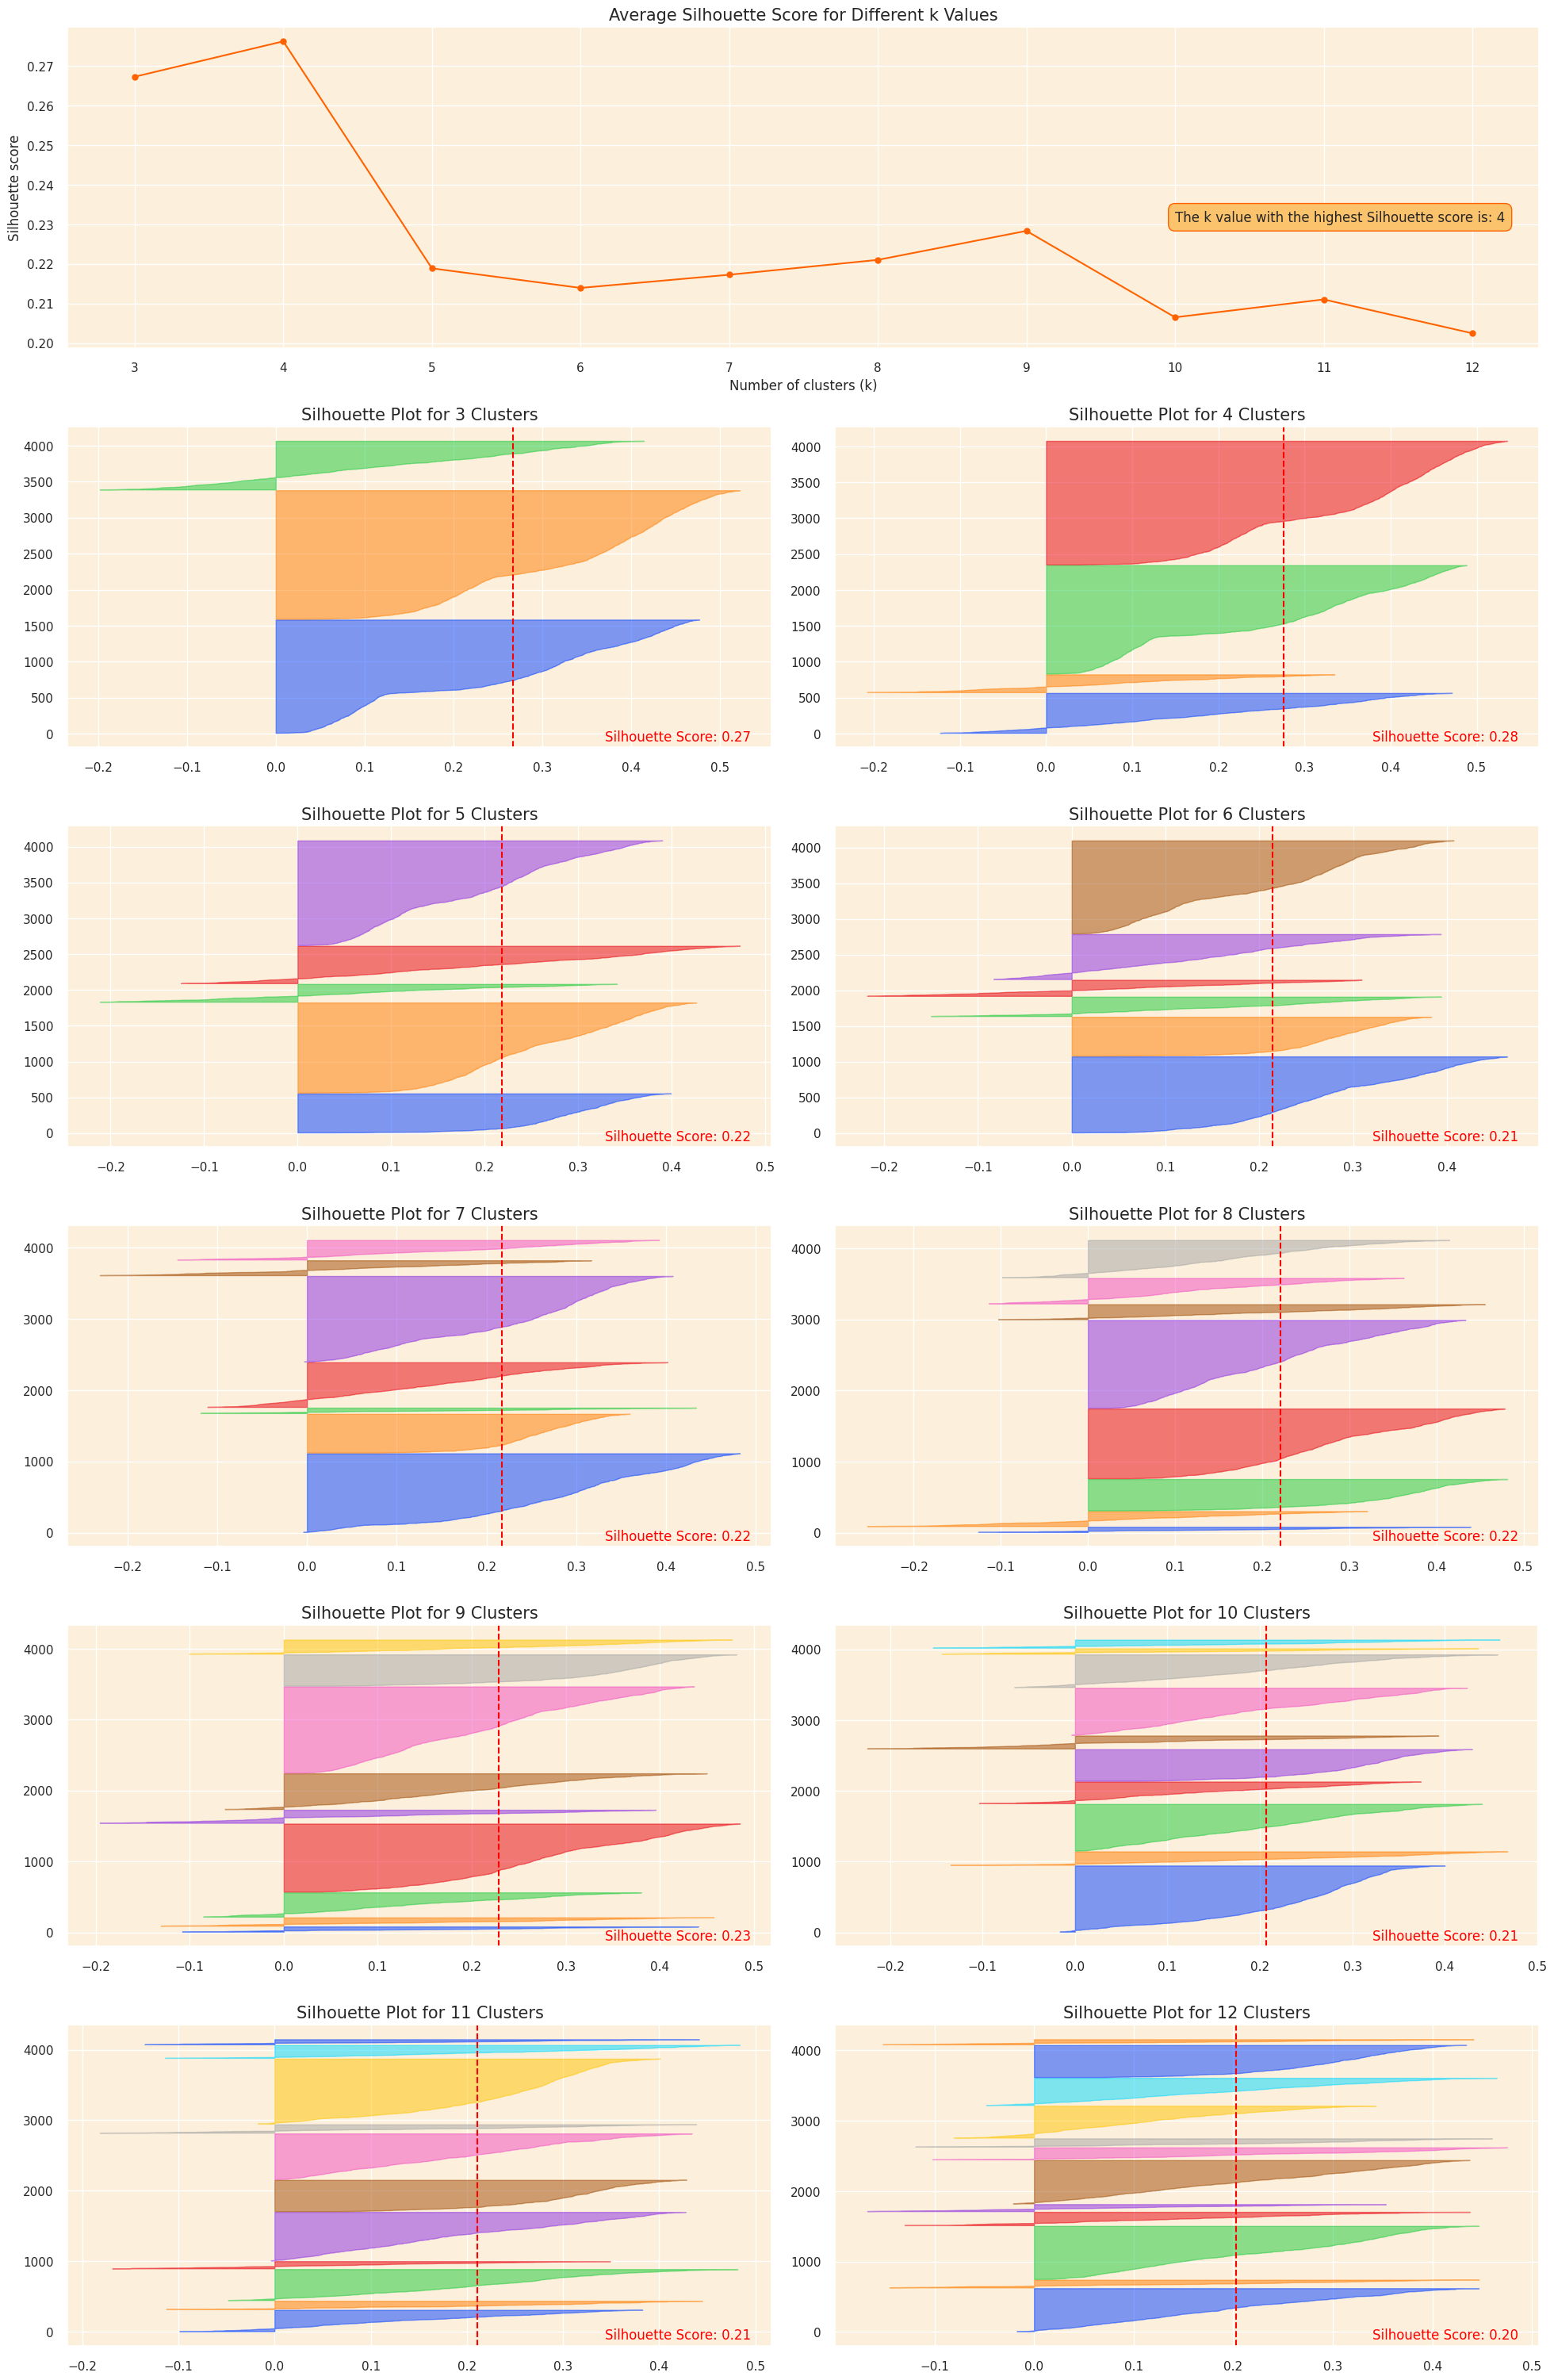

In [ ]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

In [ ]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [ ]:
# Display the first few rows of the original dataframe
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,4407902,2,6,6309,222011.1,37001.85,85,2.128378,3,8,37001.85,23143.193490,1878.917143,0
1,4408259,75,4,6996,89866.8,22466.70,21,10.884615,6,15,22466.70,12693.354067,-6342.840000,2
2,4408616,18,1,1881,89549.1,89549.10,71,0.000000,3,5,89549.10,0.000000,0.000000,0
3,4408973,310,1,588,18324.0,18324.00,16,0.000000,5,12,18324.00,0.000000,0.000000,2
4,4409687,36,7,1578,86196.6,12313.80,57,3.421053,4,10,17239.32,9070.148883,984.960000,2


<ipython-input-65-4e2adce43589>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)
<ipython-input-65-4e2adce43589>:8: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)


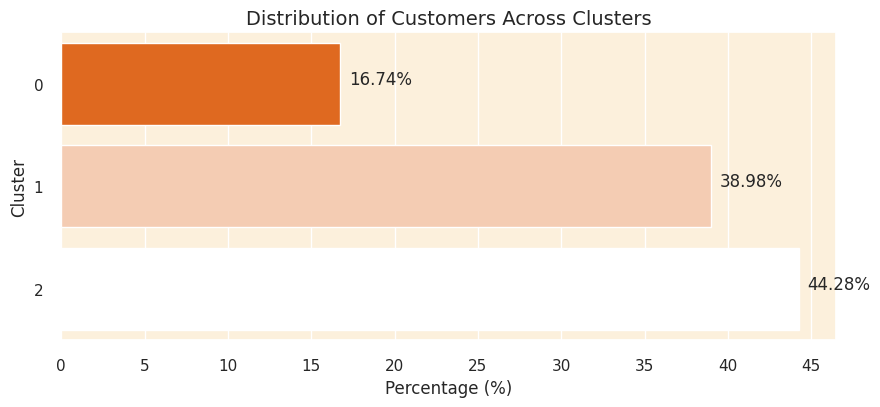

In [ ]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()


In [ ]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+--------------------+
|         Metric          |       Value        |
+-------------------------+--------------------+
| Number of Observations  |        4038        |
|    Silhouette Score     | 0.2672436441225467 |
| Calinski Harabasz Score | 1406.6647043554913 |
|  Davies Bouldin Score   | 1.2759210527178027 |
+-------------------------+--------------------+


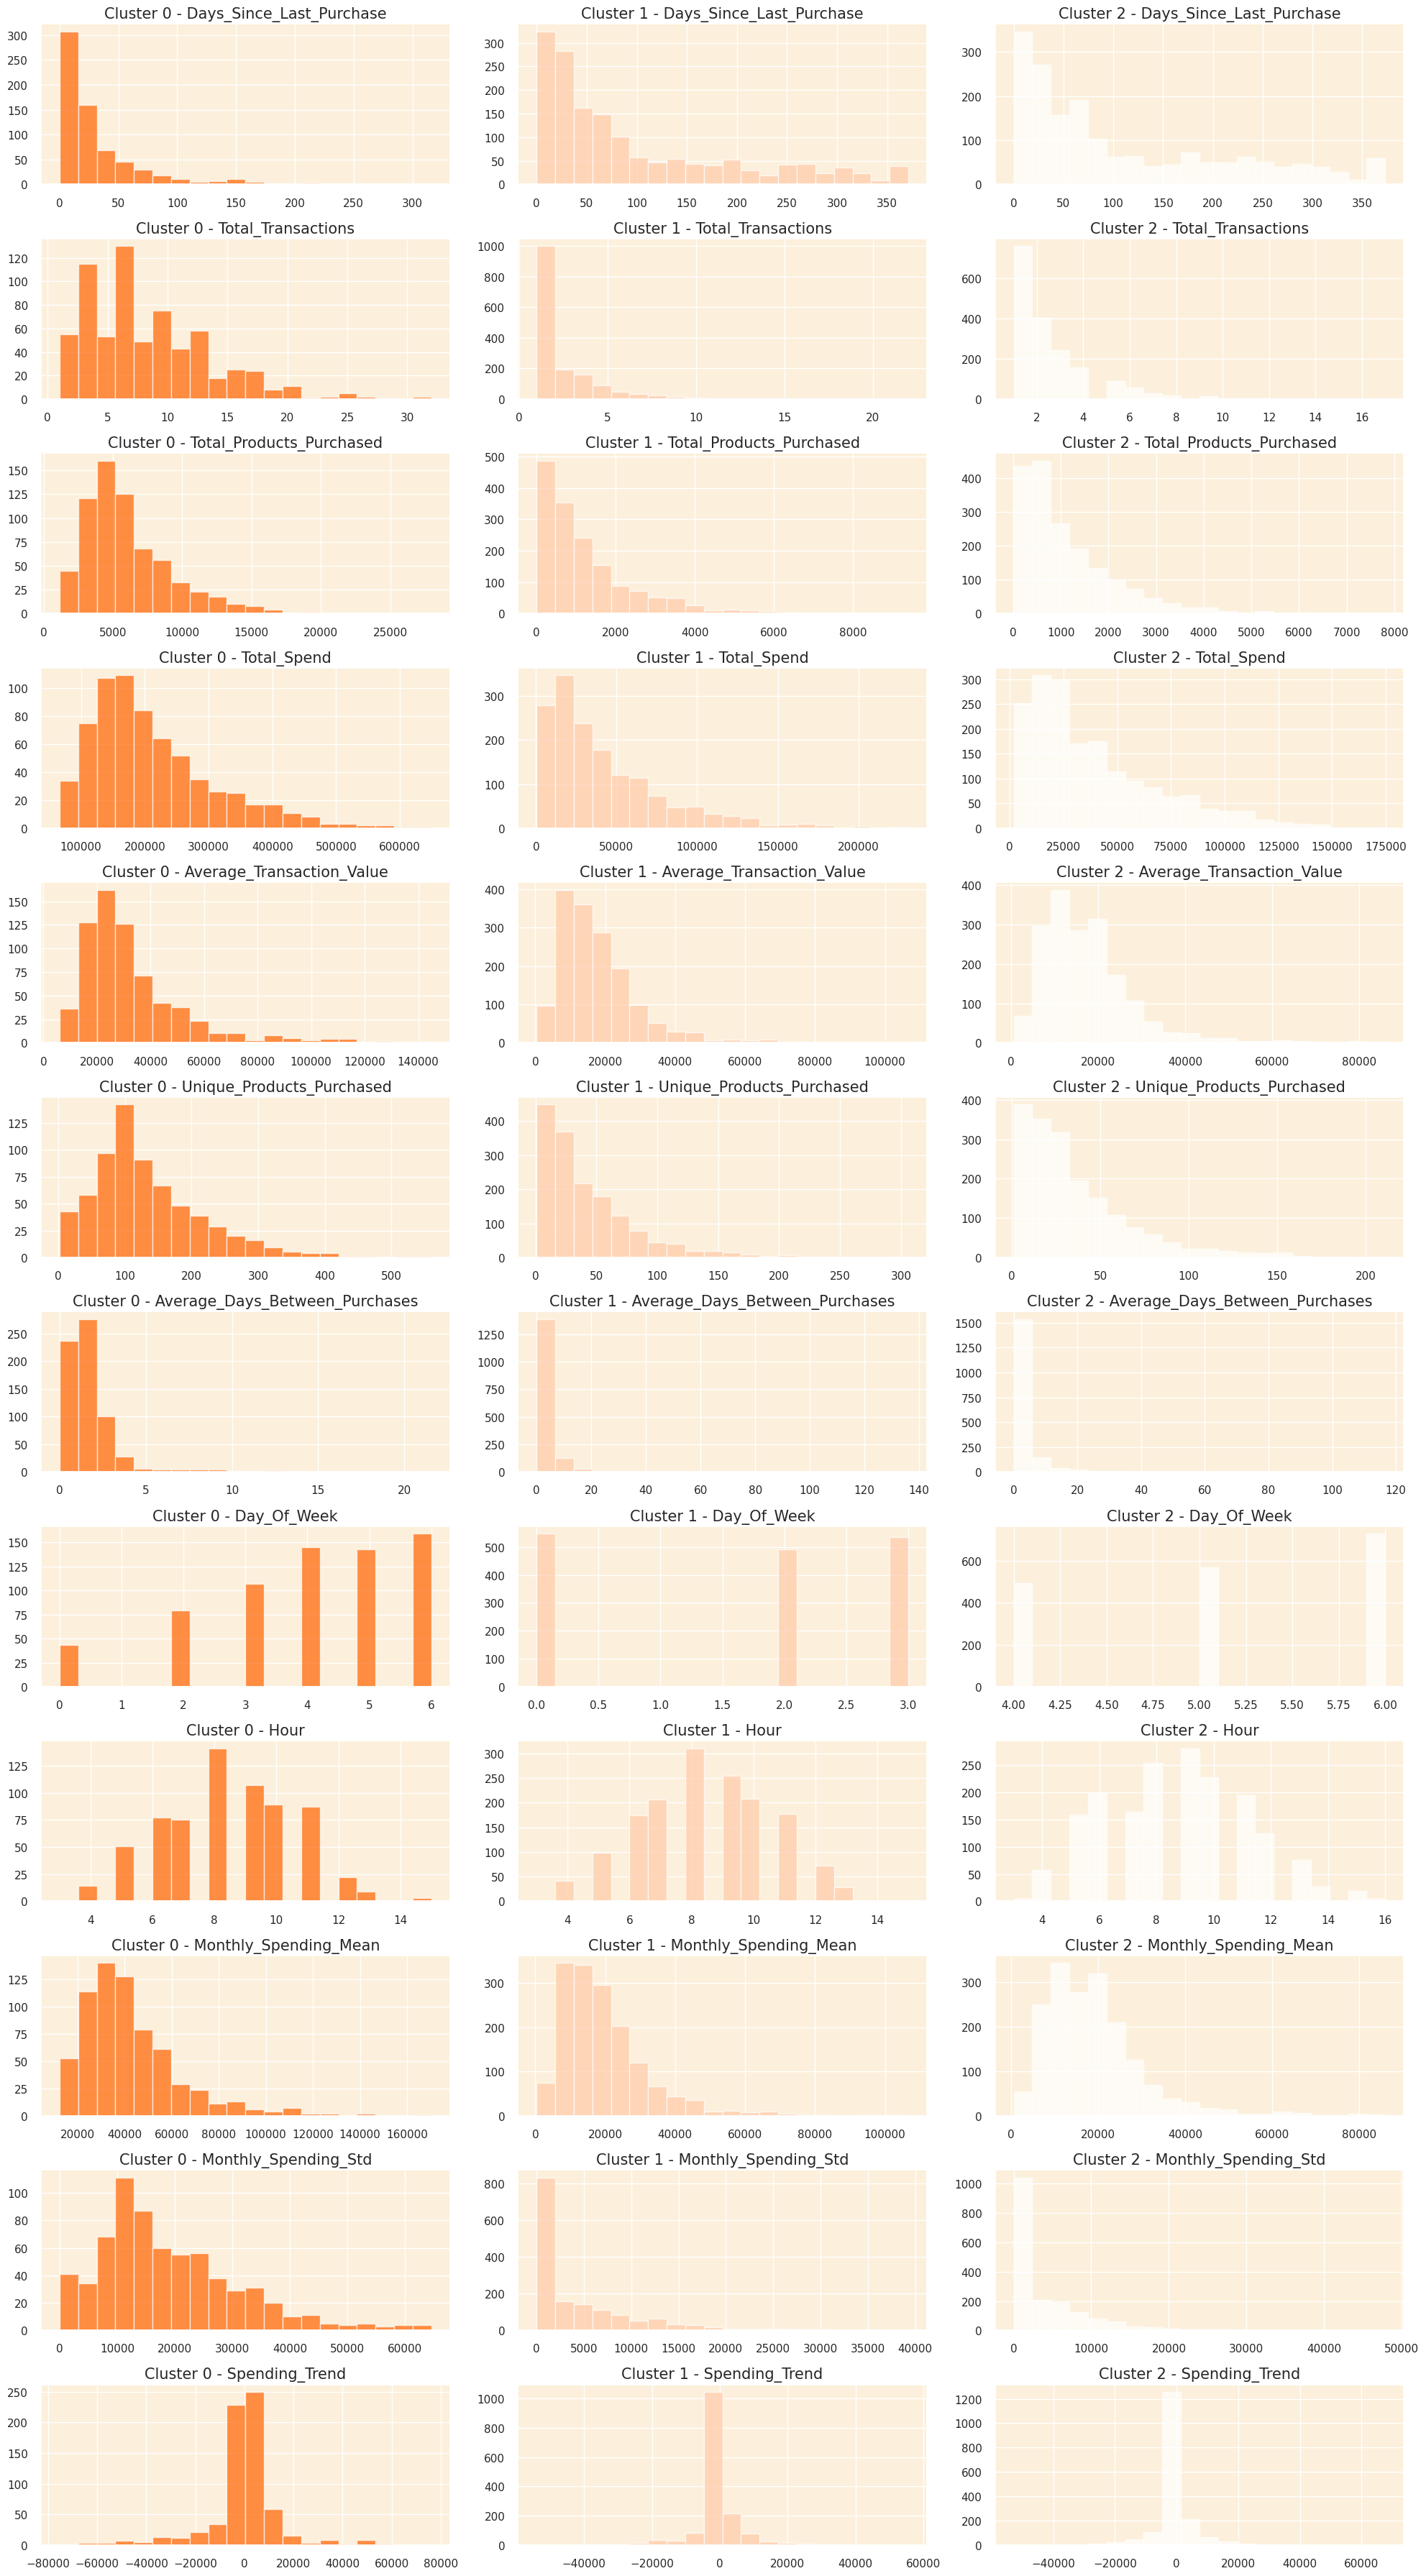

In [ ]:
# Plot histograms for each feature segmented by the clusters
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Extract the CustomerIDs of the outliers and remove their transactions from the main dataframe
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = df[~df['CustomerID'].isin(outlier_customer_ids)]

# Step 2: Ensure consistent data type for CustomerID across both dataframes before merging
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

# Step 3: Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# Step 4: Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['cluster', 'StockCode'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# Step 5: Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Step 6: Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']

    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) &
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()

        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)

        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode']].values.flatten().tolist())

# Step 7: Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode','Rec2_StockCode', 'Rec3_StockCode'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

In [ ]:
# Display 10 random rows from the customer_data_with_recommendations dataframe
specific_columns = ['cluster', 'Rec1_StockCode', 'Rec2_StockCode','Rec3_StockCode']

customer_data_with_recommendations.set_index('CustomerID')[specific_columns].sample(50)

,cluster,Rec1_StockCode,Rec2_StockCode,Rec3_StockCode
CustomerID,,,,
4705997.0,2,40609203,40996569,41114421
5999408.0,2,40609203,40996569,41114421
5191160.0,2,40609203,40996569,41114421
5645621.0,0,41102829,40609203,10721163
6356408.0,2,40609203,40996569,41114421
4803458.0,2,40609203,40996569,41114421
6316424.0,1,40996569,40609203,41102829
5450342.0,1,40996569,40609203,41102829
6225389.0,2,40609203,40996569,41114421


In [ ]:
# Savvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvve it
customer_data_with_recommendations.to_excel('/content/drive/MyDrive/customer_recommendations.xlsx', index=False)

**FP-GROWTH**

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/meeting/final_dataset.csv")
dataset.head()

,CustomerID,InvoiceNo,InvoiceDate,StockCode,Quantity,UnitPrice
0,4728845,57201714,2023-02-02 12:50:00,10707639,6,175.95
1,5740940,56550393,2022-12-26 09:06:00,11094522,3,52.80
2,4540706,57470400,2023-02-15 09:45:00,11286756,72,13.50
3,6468149,54404766,2022-06-22 07:14:00,10561290,3,25.95
4,4861292,56764233,2023-01-11 09:50:00,41106693,12,52.80


In [ ]:
# Group products by transaction
grouped_prods = dataset.groupby('InvoiceNo')['StockCode'].apply(lambda group_series: group_series.tolist()).reset_index()
groups_lists = grouped_prods['StockCode'].values.tolist()
# Convert table to list
# Set threshold of count to 2
data = list(filter(lambda x: len(x) > 2, groups_lists))

In [ ]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,4830978,4868652,4887972,4889421,4889904,4890387,4894251,4895217,5313495,7259502,...,43567578,43568544,43569027,43569510,43570476,43570959,43571442,43571925,43572408,43573374
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16278,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16279,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16280,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16281,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# use fp-growth algorithm
from mlxtend.frequent_patterns import fpgrowth

f_patterns = fpgrowth(df, min_support=0.005, use_colnames=True)
f_patterns

,support,itemsets
0,0.118590,(41114421)
1,0.032488,(40586019)
2,0.018178,(10989228)
3,0.015046,(34318611)
4,0.014678,(40768110)
...,...,...
5941,0.008107,"(11390601, 11389635)"
5942,0.005097,"(11390601, 10010187)"
5943,0.007370,"(11389635, 41102829)"
5944,0.005957,"(11389635, 11275164)"


In [ ]:
import itertools as it
from itertools import *

# help function
def partition(pred, iterable):
    t1, t2 = it.tee(iterable)
    return it.filterfalse(pred, t1), filter(pred, t2)

# divides list on all possible pairs
def part2(el_list):
    pairs = [[[x[1] for x in f] for f in partition(lambda x: x[0], zip(pattern, el_list))] \
     for pattern in product([True, False], repeat=len(el_list))]
    # remove pairs as [] -> [some content], [some content] -> []
    return pairs[1:-1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# convert dataframe to dictionary
supports = f_patterns['support'].to_list()
itemsets = f_patterns['itemsets'].to_list()

patterns_dict = {}
for x in range(len(itemsets)):
    patterns_dict[tuple(sorted(itemsets[x]))] = supports[x]

# generate asssociation_rules
as_rules_dict = {'left': [], 'right': [], 'confidence': []}
for pattern, support in patterns_dict.items():
    if len(pattern) > 1:
        upper_support = support
        as_rules = part2(pattern)

        for as_r in as_rules:
            left_part = sorted(as_r[0])
            right_part = as_r[1]
            lower_support = patterns_dict[tuple(left_part)]
            conf = upper_support / lower_support

            as_rules_dict['left'].append(left_part)
            as_rules_dict['right'].append(right_part)
            as_rules_dict['confidence'].append(conf)


strong_as_rules = pd.DataFrame.from_dict(as_rules_dict)
# sort by confidence, remove all rules with confidence lower than 0.8
strong_as_rules = strong_as_rules.sort_values('confidence', ascending=False)
strong_as_rules = strong_as_rules[strong_as_rules['confidence'] > 0.8]

strong_as_rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,left,right,confidence
13032,"[11068440, 11068923, 11069889, 11070372, 11070...",[11069406],0.992481
13024,"[11068440, 11069406, 11069889, 11070372, 11070...",[11068923],0.992481
26420,"[11249082, 11249565, 11250048]",[11248599],0.988889
25392,"[11191122, 11192088, 11192571, 11193054]",[11191605],0.988636
12742,"[11068440, 11069406, 11069889, 11070855]",[11068923],0.985915
...,...,...,...
26267,"[11236041, 11236524]",[11237007],0.801325
12477,[11069406],"[11068923, 11069889, 11070372]",0.801075
12474,[11070372],"[11068923, 11069406, 11069889]",0.801075
12629,[11069406],"[11068923, 11070855]",0.801075


In [ ]:
# Savvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvve it
# strong_as_rules.to_excel('/content/drive/MyDrive/association_rules_online_retail_II.xlsx', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
